In [3]:
from google.colab import drive
drive.mount('/content/drive')#allocation my drive space to this note book, so i can use the path

Mounted at /content/drive


In [4]:
#packages that are useful
import numpy as np #linear algebra
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)
import os #functions for interacting with the operating system
#for dirname, _, filenames in os.walk('/content/drive/MyDrive/Final_project/dataset_amazon'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
import pandas as pd #data analysis toolkit
import numpy as np #for array processing
import matplotlib.pyplot as plt #plot the figures
%matplotlib inline 
import seaborn as sns#data visualization
import re #regularization
import nltk #dealing with nature language
from nltk.corpus import  stopwords #massive dump of all kinds of natural language data sets
from nltk.stem.porter import PorterStemmer #Stem extraction based on porter
from nltk.tokenize import word_tokenize, sent_tokenize #using for text spliting
from nltk.stem.wordnet import WordNetLemmatizer #Same word form induction, used for dimensionality reduction
from sklearn.model_selection import train_test_split #split the dataset into training set and test set
from sklearn.model_selection import cross_val_score, GridSearchCV #Greedy algorithm automatically adjusts parameters
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer #Text preprocessing based on word frequency
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import string #string methods
import random 
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

/content/drive/MyDrive/Final_project/dataset_amazon/Musical_instruments_reviews.csv
/content/drive/MyDrive/Final_project/dataset_amazon/Musical_Instruments_5.json
/content/drive/MyDrive/Final_project/dataset_amazon/fuzzydataset.csv
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
data_raw = pd.read_csv('dataset_amazon/Musical_instruments_reviews.csv')
data_raw.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [6]:
data_raw.columns = data_raw.columns.str.lower() #Change the name of each column to lowercase 
print(data_raw.columns) #Preview each column name
print(data_raw.isnull().sum()) #Confirm that there is no blank data in reviewtext and summary.
print('Now the shape of our data is {} x {}.'.format(data_raw.shape[0], data_raw.shape[1])) #Preview the dimension of data

Index(['reviewerid', 'asin', 'reviewername', 'helpful', 'reviewtext',
       'overall', 'summary', 'unixreviewtime', 'reviewtime'],
      dtype='object')
reviewerid         0
asin               0
reviewername      27
helpful            0
reviewtext         7
overall            0
summary            0
unixreviewtime     0
reviewtime         0
dtype: int64
Now the shape of our data is 10261 x 9.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Ratings')

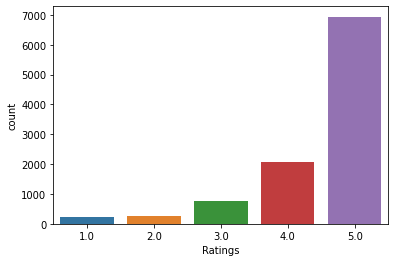

In [7]:
#the distribution of overall data
sns.countplot(data_raw.overall)
plt.xlabel('Ratings')

In [8]:
#use sentiment classes to describe the overall values
data_raw['sentiment'] = data_raw.overall.replace({
    1:'negative',
    2:'negative',
    3:'neutral',
    4:'positive',
    5:'positive'
})

In [9]:
#create the nature language data with summary + review, and the sentiment is the output
X_raw = data_raw['reviewtext'] + ' ' + data_raw['summary']
DataSet_y = data_raw['sentiment']

In [10]:
#convert the  raw language data into string
X_raw = X_raw.astype(str)

In [13]:
#Preprocessing of language data
def nlpre(X_raw):
    
    ##sub functions
    #punctuations remove function
    def remove_punct(X_fcn):
        string1 = X_fcn.lower()
        translation_table = dict.fromkeys(map(ord, string.punctuation),' ') 
        string2 = string1.translate(translation_table)
        return string2
    #stopwords remove function  
    def remove_stopwords(X_fcn):
        pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*') 
        string2 = pattern.sub(' ', X_fcn)
        return string2
    #tokenizing function 
    def tokenize_words(X_fcn):
        words = nltk.word_tokenize(X_fcn) 
        return words
    #lemmatizing function 
    lemmatizer = WordNetLemmatizer()
    def lemmatize_words(X_fcn):
        words = lemmatizer.lemmatize(X_fcn) 
        return words

    ##Processing part
    X_raw_clear_punct = []
    for i in range(len(X_raw)):
        test_data = remove_punct(X_raw[i]) #replace !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ with space
        X_raw_clear_punct.append(test_data)
        
    X_raw_clear_stopwords = []
    for i in range(len(X_raw)):
        test_data = remove_stopwords(X_raw[i]) #remove the words that does not have so much meaning in this process
        X_raw_clear_stopwords.append(test_data)
        
    X_raw_tokenized_words = []
    for i in range(len(X_raw)):
        test_data = tokenize_words(X_raw[i]) #devide the string into substring
        X_raw_tokenized_words.append(test_data)
   
    X_raw_lemmatized_words = []
    for i in range(len(X_raw)):
        test_data = lemmatize_words(X_raw[i]) #merge the same words
        X_raw_lemmatized_words.append(test_data)
        
    #creating the bag of words model
    cv = CountVectorizer(max_features=1000) #Declare a word to word vector transformation，specifies the number of elements of the vectorized corpus
    X_raw_vector = cv.fit_transform(X_raw_lemmatized_words).toarray() #convert to matrix
    
    tfidf = TfidfTransformer()
    X_processed_tfidf = tfidf.fit_transform(X_raw_vector).toarray() #scale down the impact of tokens that occur very frequently in a given corpus
    
    return X_processed_tfidf
    

In [12]:
#use nlp preprocessing and split dataset into training set and test set
DataSet_X = nlpre(X_raw)
X_train, X_val, y_train, y_val = train_test_split(DataSet_X, DataSet_y , test_size=0.30, random_state = 7) #ensure we have the same TestSet and TrainingSet each time

In [14]:
#Preview the shape of word-vectors
print(DataSet_X)
print(DataSet_X.shape)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.05282621 0.         0.        ]
 [0.         0.         0.         ... 0.05885796 0.08231229 0.        ]
 ...
 [0.         0.         0.         ... 0.04540553 0.         0.        ]
 [0.         0.         0.         ... 0.         0.03110653 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(10261, 1000)


In [15]:
embedding_dim=32
num_vocabs=5000

model = Sequential()
model.add(Embedding(num_vocabs, embedding_dim, input_length=DataSet_X.shape[1])) #add an Embedding layer that have 5000 words in vocabulary, convert the vord vector into a dimension of 32.
model.add(LSTM(100, recurrent_dropout = 0.1)) #add a LSTM layer for reccurent process, and with a dropout among the linear transformation among linear trans formation state
model.add(Dense(3,activation='softmax')) #,use soft max fuction as activation function.
print(model.summary())

#Use the cross entropy in assignment 2 as the loss function, and the statistical accuracy method is simple accuracy.
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 32)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
Total params: 213,503
Trainable params: 213,503
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
# convert sentiments state in y_train to dummies
y_train_dummies = pd.get_dummies(y_train).values
print('y_train_dummies',y_train_dummies)
print('y_train:',y_train)
print('Label tensor\'s shape: ', y_train_dummies.shape)

y_train_dummies [[0 0 1]
 [0 0 1]
 [1 0 0]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]
y_train: 5841    positive
6320    positive
5936    negative
7498    positive
1882    positive
          ...   
919     positive
4307    positive
5699    positive
537     positive
9412    positive
Name: sentiment, Length: 7182, dtype: object
Label tensor's shape:  (7182, 3)


In [17]:
#training part
hist = model.fit(X_train, y_train_dummies, epochs=5, batch_size=32)

Epoch 1/5
225/225 [==============================] - 379s 2s/step - loss: 0.5313 - accuracy: 0.8852
Epoch 2/5
225/225 [==============================] - 376s 2s/step - loss: 0.4395 - accuracy: 0.8837
Epoch 3/5
225/225 [==============================] - 375s 2s/step - loss: 0.4726 - accuracy: 0.8704
Epoch 4/5
225/225 [==============================] - 381s 2s/step - loss: 0.4448 - accuracy: 0.8820
Epoch 5/5
225/225 [==============================] - 379s 2s/step - loss: 0.4478 - accuracy: 0.8805


In [19]:
model.save('model/Amazon_Instru_Sentiment_Analy.h5')

In [20]:
# convert sentiments state in y_val to dummies
y_val_dummies = pd.get_dummies(y_val).values
print('Shape of Label tensor: ', y_val_dummies.shape)

Shape of Label tensor:  (3079, 3)


In [23]:
# model validation
from keras.models import load_model

model = load_model('model/Amazon_Instru_Sentiment_Analy.h5')
scores = model.evaluate(X_val, y_val_dummies)

LSTM_accuracy = scores[1]*100

print('Validation accuracy: ', LSTM_accuracy, '%')


97/97 [==============================] - 22s 220ms/step - loss: 0.4633 - accuracy: 0.8756
Validation accuracy:  87.56089806556702 %


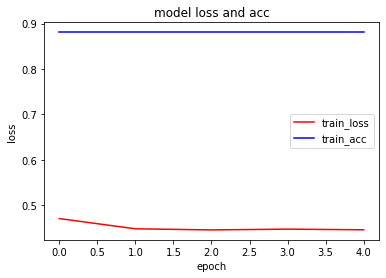

[0.46333596110343933, 0.8756089806556702]


In [31]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'],color='r')
plt.plot(hist.history['accuracy'],color='b')
plt.title('model loss and acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'train_acc'], loc='center right')
plt.show()

print(scores)